In [1]:
import pickle
from typing import Dict

from fancyimpute import IterativeImputer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
CV = 5
NJOBS = 10
RANDOM_STATE = 42

In [3]:
# open saved data
x_df = pd.read_pickle("features.pkl", compression="gzip")
y_df = pd.read_pickle("labels.pkl", compression="gzip")

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=RANDOM_STATE)

### Logistic Regression

In [4]:
# Create a logistic regression model
pipeline_lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=10000, solver="saga"))])

# Define the parameter grid for grid search
param_grid_lr = {'lr__C': [0.01, 0.1, 1, 10],
                 'lr__penalty': ['l1', 'l2']}

# Create a grid search object with 5-fold cross-validation
grid_search_lr = GridSearchCV(pipeline_lr, param_grid=param_grid_lr, cv=CV, scoring='roc_auc', n_jobs=NJOBS)

# Fit the grid search object on the training set
grid_search_lr.fit(X_train, y_train)

# Print the best parameters and the best AUC score
print("Best parameters: ", grid_search_lr.best_params_)
print("Best AUC score: ", grid_search_lr.best_score_)

Best parameters:  {'lr__C': 0.1, 'lr__penalty': 'l1'}
Best AUC score:  0.7630672546731448


Cross-validation AUC scores: [0.7655 0.7541 0.7689 0.7692 0.7601]
Train AUC score: 0.7631
Test AUC score: 0.7704


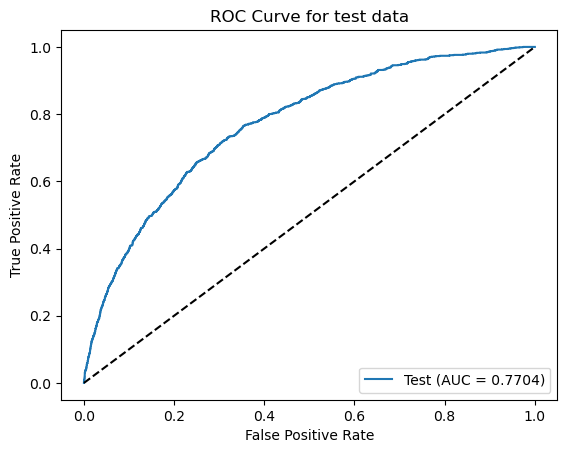

In [5]:
def plot(y_test: np.array, y_pred_proba: np.array, test_auc_score: float):
    # Compute the false positive rate and true positive rate for testing set
    test_fpr, test_tpr, _ = roc_curve(y_test, y_pred_proba)

    # Plot the ROC curve for the testing set on the same graph
    plt.plot(test_fpr, test_tpr, label='Test (AUC = {:.4f})'.format(test_auc_score))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for test data')
    plt.legend(loc="lower right")
    plt.show()

def evaluate(grid_search: GridSearchCV, precision: int=4, n_splits: int=5):
    # Get the best model from the grid search object
    best_model = grid_search.best_estimator_

    # Evaluate the model using 5-fold cross-validation and AUC score
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_splits)

    # Print the cross-validation scores
    print(f"Cross-validation AUC scores: {cv_scores.round(precision)}")

    # Fit the best model on the entire training set and get the AUC score on the testing set
    best_model = clone(best_model)
    best_model.fit(X_train, y_train)
    y_pred_proba = best_model.predict_proba(X_test)[:,1]
    test_auc_score = roc_auc_score(y_test, y_pred_proba)

    # Print the AUC score
    train_auc_score = grid_search.best_score_
    print(f"Train AUC score: {round(train_auc_score, precision)}" )
    print(f"Test AUC score: {round(test_auc_score, precision)}")

    # plot
    plot(y_test, y_pred_proba, test_auc_score)
    return best_model

best_lr = evaluate(grid_search_lr)

In [6]:
# Save the logistic model
with open('best_lr.pkl', 'wb') as f:
    pickle.dump(best_lr, f, pickle.HIGHEST_PROTOCOL)

### Model 1: Random Forest

In [44]:
# Create a random forest model
pipeline_rf = Pipeline([('scaler', StandardScaler()),
                         ('rf', RandomForestClassifier(n_jobs=10))])

# Define the parameter grid for grid search
param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [3, 5, 7],
    'rf__min_samples_split': [2, 4, 6],
    'rf__min_samples_leaf': [1, 2, 3],
}

# Create a grid search object with 5-fold cross-validation
grid_search_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, cv=CV, scoring='roc_auc', n_jobs=NJOBS)

# Fit the grid search object on the training set
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and the best AUC score
print("Best parameters: ", grid_search_rf.best_params_)
print("Best AUC score: ", grid_search_rf.best_score_)

Best parameters:  {'rf__max_depth': 7, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 6, 'rf__n_estimators': 200}
Best AUC score:  0.7582084570170979


Cross-validation AUC scores: [0.7622 0.7662 0.7513 0.7457 0.7555]
Train AUC score: 0.7582
Test AUC score: 0.7512


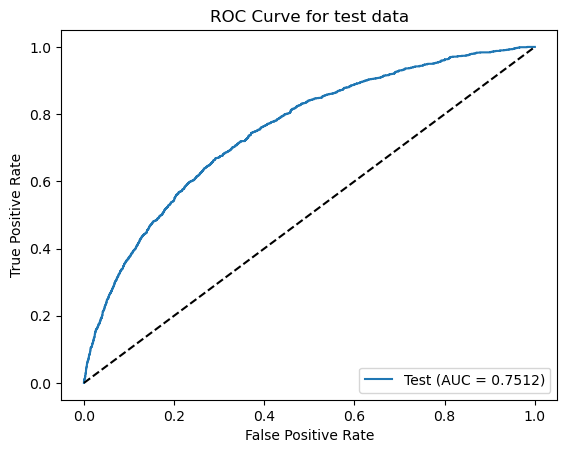

In [51]:
best_rf = evaluate(grid_search_rf)

In [60]:
feature_importance = pd.Series(index=X_train.columns, data=best_rf["rf"].feature_importances_)
feature_importance.sort_values(ascending=False).round(4).head()

x7_percentage    0.1987
x4               0.0801
x47              0.0554
x16              0.0420
x40              0.0408
dtype: float64

In [46]:
# Save the random forest model
with open('best_rf.pkl', 'wb') as f:
    pickle.dump(best_rf, f, pickle.HIGHEST_PROTOCOL)

### Model 2: Neural Network

In [7]:
# Create a mlp model
pipeline_mlp = Pipeline([('scaler', StandardScaler()),
                         ('mlp', MLPClassifier(max_iter=1000, random_state=RANDOM_STATE, early_stopping=True))])

# Define the parameter grid for grid search
param_grid_mlp = {'mlp__hidden_layer_sizes': [[50] * i for i in range(1, 8, 2)],
                  'mlp__activation': ['relu', 'logistic', 'tanh']}

# Create a grid search object with 5-fold cross-validation
grid_search_mlp = GridSearchCV(pipeline_mlp, param_grid=param_grid_mlp, cv=CV, scoring='roc_auc', n_jobs=NJOBS)

# Fit the grid search object on the training set
grid_search_mlp.fit(X_train, y_train)

# Print the best parameters and the best AUC score
print("Best parameters: ", grid_search_mlp.best_params_)
print("Best AUC score: ", grid_search_mlp.best_score_)

Best parameters:  {'mlp__activation': 'logistic', 'mlp__hidden_layer_sizes': [50, 50, 50, 50, 50]}
Best AUC score:  0.770291788482272


Cross-validation AUC scores: [0.7691 0.7795 0.7715 0.7907 0.7671]
Train AUC score: 0.7703
Test AUC score: 0.7846


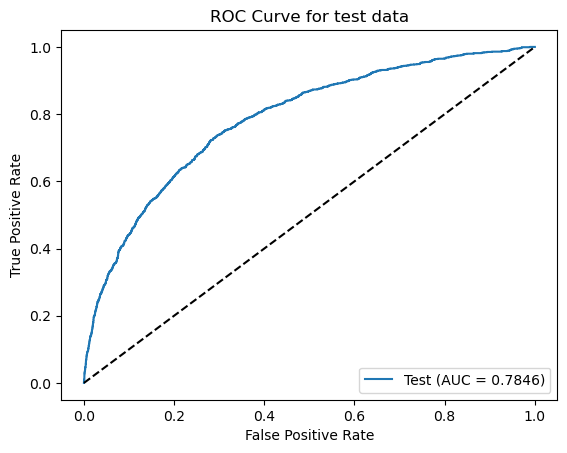

In [8]:
best_mlp = evaluate(grid_search_mlp)

In [9]:
# Save the mlp model
with open('best_mlp.pkl', 'wb') as f:
    pickle.dump(best_mlp, f, pickle.HIGHEST_PROTOCOL)

### Generate output

In [10]:
with open('imputer.pkl', 'rb') as f:
    imp = pickle.load(f)

with open('label_encoders.pkl', 'rb') as f:
    lebel_encoders = pickle.load(f)

with open('column_transfomer.pkl', 'rb') as f:
    ct = pickle.load(f)

In [11]:
def impute_most_frequent(col):
    return col.value_counts().index[0]

def transform_data(df: pd.DataFrame, imp: IterativeImputer, lebel_encoders: Dict[str, LabelEncoder], ct: ColumnTransformer) -> pd.DataFrame:
    category_df = df.loc[:,df.dtypes == np.object]
    category_df['x3'] = category_df['x3'].apply(lambda x: x[:3])
    category_df = category_df.rename(columns={'x3': 'weekday',
                                              'x24': 'gender',
                                              'x33': 'state',
                                              'x60': 'month',
                                              'x65': 'insurance_company',
                                              'x77': 'car_brand',
                                              'x7': 'x7_percentage',
                                              'x19': 'x19_money'})
    category_df['x7_percentage'] = category_df['x7_percentage'].str.replace('%', '').astype(float)
    category_df['x19_money'] = category_df['x19_money'].str.replace('$','').astype(float)
    category_df = category_df.drop(columns=['x39'])
    float_df = df.loc[:,df.dtypes == np.float64]
    float_columns = ['x7_percentage','x19_money']
    float_df = pd.concat([float_df, category_df[float_columns]], axis=1)
    int_df = df.loc[:,df.dtypes == np.int64]
    bool_columns = ["x31", "x93", "x99"]
    for col in bool_columns:
        int_df[col] = (category_df[col] == "yes").astype(int)

    category_df = category_df.drop(columns=float_columns + bool_columns)
    category_df = category_df.apply(lambda col: col.fillna(impute_most_frequent(col)))
    cat_df = category_df.copy(deep=True)
    for col in category_df.columns:
        cat_df[col] = lebel_encoders[col].transform(category_df[col])

    data_encoded = pd.DataFrame(ct.transform(cat_df))
    column_names = ct.named_transformers_['onehot_prefix'].named_steps['onehot'].get_feature_names_out(cat_df.columns)
    data_encoded.columns = column_names.tolist() + cat_df.columns[len(column_names):].tolist()

    num_df = pd.concat([float_df, int_df], axis=1)
    imp_num_df = pd.DataFrame(imp.transform(num_df))
    imp_num_df.index = num_df.index
    imp_num_df.columns = num_df.columns
    return pd.concat([data_encoded, imp_num_df], axis=1)

df_test = pd.read_csv("data/exercise_40_test.csv")
df_test = transform_data(df_test, imp, lebel_encoders, ct)
df_test.head()

/tmp/ipykernel_21092/1116561648.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  category_df = df.loc[:,df.dtypes == np.object]
/tmp/ipykernel_21092/1116561648.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['x3'] = category_df['x3'].apply(lambda x: x[:3])
/tmp/ipykernel_21092/1116561648.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal str

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,gender_0,gender_1,state_0,...,x96,x97,x100,x7_percentage,x19_money,x59,x98,x31,x93,x99
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,12.438759,7.298306,93.567120,0.0098,120.216190,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,10.386987,12.527094,98.607486,0.0076,-267.562586,0.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,11.328177,11.628247,94.578246,-0.0005,-311.292903,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,10.064961,10.550014,100.346261,-0.0160,2229.149400,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,9.255766,12.716137,102.578918,0.0186,-469.049530,0.0,1.0,1.0,1.0,1.0


In [22]:
glmresults = best_lr.predict_proba(df_test)[:, 1]
nonglmresults = best_mlp.predict_proba(df_test)[:, 1]
pd.Series(glmresults).to_csv("prediction/glmresults.csv", index=None, header=None)
pd.Series(nonglmresults).to_csv("prediction/nonglmresults.csv", index=None, header=None)